<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0] ,index_col='datetime')

In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные загружены и изучены . В таблице данные заказов такси с марта по август 2018 года , имеется 2 столбца - число заказов такси 'num_orders' и время заказа такси. 

In [4]:
taxi.sort_index(inplace=True) #отсортируем признаки 

In [5]:
taxi.index.is_monotonic 

True

In [6]:
taxi = taxi.resample('1H').sum()
taxi.head()#выполним ресемплирование по 1 часу

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

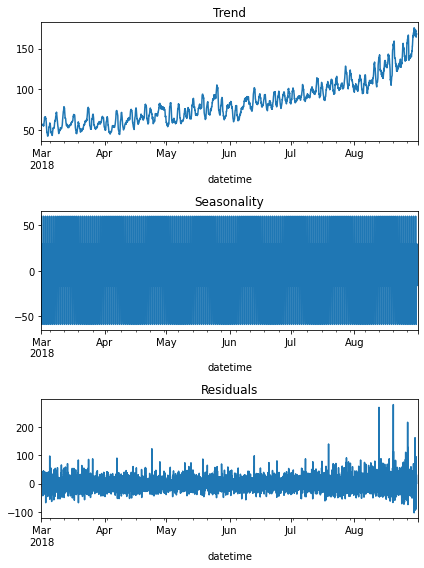

In [7]:
decomposed = seasonal_decompose(taxi) #построим гарфики,разложим временной ряд

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Cреднее количество заказов увеличивается ближе к летнему сезону. Что касаемо сезонности -  Нельзя увидеть закономерности, если есть данные только за год.

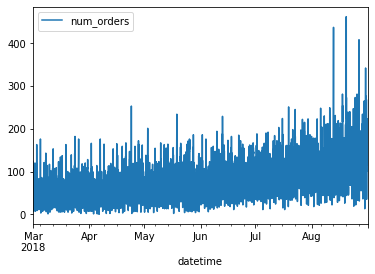

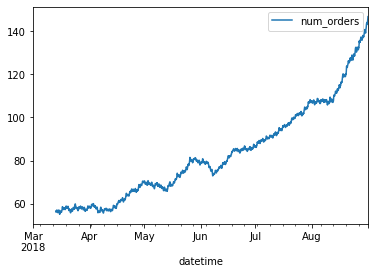

In [8]:
taxi.plot()
plt.show()

# Применим скользящее среднее

taxi.rolling(300).mean().plot()
plt.show()


Среднее количество заказов такси к середине лета увиличевается в два раза , это можно обьяснить тем , что летом все люди в отпуске и больше гуляют , так же возможно из-за роста компании в целом .

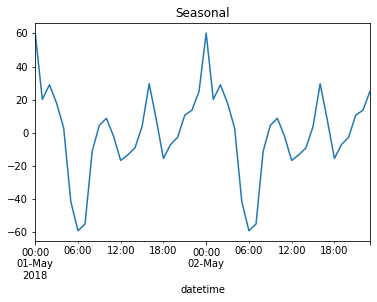

In [9]:
decomposed.seasonal['2018-05-01' : '2018-05-02'].plot(title='Seasonal');

Среднее количество заказов такси имеет тенденцию увеличиватся в 12 ч. вечера и 18 ч вечера, а на спад идет с 2 ч. ночи до 6. ч утра .

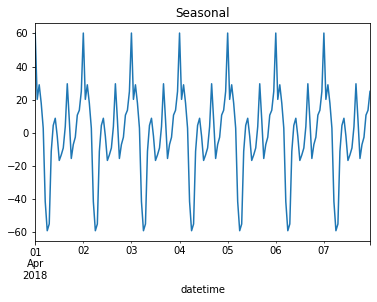

In [10]:
decomposed.seasonal['2018-04-01' : '2018-04-07'].plot(title='Seasonal');

Если рассматривать график на среднее количесвто заказов такси в дневном цикле то гарфик достаточно равномерный. Разницы в дне недели особо нет .

## Обучение

In [11]:
def make_features(taxi, max_lag,rolling_mean_size): #функция для создания новых признаков 

    #taxi['year'] = taxi.index.year
    #taxi['month'] = taxi.index.month
    #taxi['day'] = taxi.index.day
    taxi['dayofweek'] = taxi.index.dayofweek
    taxi['hour'] = taxi.index.hour
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)
    
    
    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return taxi
    
taxi = make_features(taxi, 30, 30)    

In [12]:
print(taxi.shape)
taxi = taxi.dropna()
print(taxi.shape)

(4416, 34)
(4386, 34)


In [13]:
x_taxi = taxi.drop('num_orders', axis=1) #разбиваем данные
y_taxi = taxi['num_orders']
x_taxi_train, x_taxi_test, y_taxi_train, y_taxi_test = train_test_split(x_taxi, y_taxi, test_size=0.1 , shuffle=False)
x_taxi_train.shape, x_taxi_test.shape, y_taxi_train.shape, y_taxi_test.shape

((3947, 33), (439, 33), (3947,), (439,))

In [14]:
x_taxi_train

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 06:00:00,4,6,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.133333
2018-03-02 07:00:00,4,7,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,54.366667
2018-03-02 08:00:00,4,8,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,51.766667
2018-03-02 09:00:00,4,9,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,50.933333
2018-03-02 10:00:00,4,10,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,50.233333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 12:00:00,0,12,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,...,104.0,120.0,123.0,81.0,108.0,108.0,97.0,24.0,22.0,126.566667
2018-08-13 13:00:00,0,13,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,...,149.0,104.0,120.0,123.0,81.0,108.0,108.0,97.0,24.0,128.900000
2018-08-13 14:00:00,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,...,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,97.0,132.066667


In [15]:
x_taxi_test

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 17:00:00,0,17,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,135.666667
2018-08-13 18:00:00,0,18,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,...,98.0,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,138.033333
2018-08-13 19:00:00,0,19,104.0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,...,135.0,98.0,82.0,78.0,115.0,153.0,149.0,104.0,120.0,137.400000
2018-08-13 20:00:00,0,20,91.0,104.0,152.0,144.0,175.0,102.0,119.0,92.0,...,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,104.0,136.433333
2018-08-13 21:00:00,0,21,82.0,91.0,104.0,152.0,144.0,175.0,102.0,119.0,...,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,135.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,...,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,154.0,171.033333
2018-08-31 20:00:00,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,170.433333
2018-08-31 21:00:00,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,172.533333


Обучим модель

In [16]:
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=8)

In [ ]:
l = lgb.LGBMRegressor()

params = {
    'learning_rate' : [0.1, 0.25, 0.5],
    'n_estimators' : range(200, 1201, 200),
    'objective' : ['root_mean_squared_error']
}


     

gs = GridSearchCV(l, param_grid=params, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=splits, verbose=1)


     

gs.fit(x_taxi_train, y_taxi_train)
gs.best_score_

In [18]:
regr_best = gs.best_estimator_
regr_best

LGBMRegressor(n_estimators=200, objective='root_mean_squared_error')

In [19]:
train_res= mean_squared_error(y_taxi_train, regr_best.predict(x_taxi_train), squared=False)
test_res= mean_squared_error(y_taxi_test, regr_best.predict(x_taxi_test), squared=False)
print('Train_RMSE:', round(train_res))
print('Test_RMSE:', round(test_res)) 

Train_RMSE: 8
Test_RMSE: 42


В ходе выполнения работы  было проведено ресемплирование данных, созданы признаки и обучена модель . Добились результата RMSE 42 на тестовой выборке LGBMRegressor

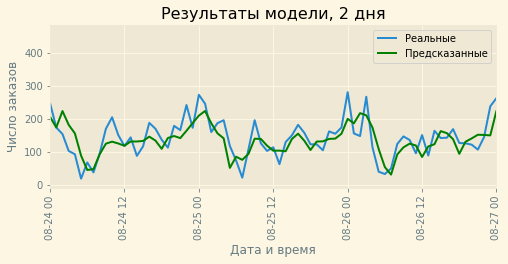

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48